# Biogas Project

Dieses Praktium orientiert sich am Kapitel 6 (RNASeq und Biogas – Identifikation Biogas-produzierender Bakterien) meines Buches *Bioinformatik für Anwender*. Ich verzichte daher auf eine Beschreibung der Befehle.

## Preparations

In [ ]:
%%bash
cd ~
mkdir RNASeq

In [ ]:
%cd RNASeq/

In [ ]:
!pwd

In [ ]:
%cd ~

In [ ]:
!ls

In [ ]:
%cd RNASeq/

### Loading Data

In [ ]:
!wget -q 'datenmassen.hs-mittweida.de/biogas.fastq.gz'

In [ ]:
!gunzip biogas.fastq.gz

In [ ]:
!head -4 biogas.fastq

In [ ]:
%%bash
wget -q 'datenmassen.hs-mittweida.de/16s-archaea.fasta.gz'
gunzip 16s-archaea.fasta.gz
head -1 16s-archaea.fasta

In [ ]:
! awk '{ORS="";if($0~/>/){print "\n"$O"\t"}else{print $0}}' 16s-archaea.fasta | sed '1d' | egrep -vi '(uncultured|enrichment|unidentified|candidatus|sp\.)' | sed 's/;.*;/ /' | sed 's/\t/\n/' > 16s-archaea-kurz.fasta

### Installation of Trimmomatic

In [ ]:
!pkexec apt-get -y install trimmomatic #prompt for pwd and ommit Y/N

In [ ]:
!java -jar /usr/share/java/trimmomatic.jar

In [ ]:
!ls

### Installation of FastQC

In [ ]:
!pkexec apt-get -y install fastqc

In [ ]:
!fastqc --version

### Installation of FastX-Toolkit

In [ ]:
!wget 'http://ftp.de.debian.org/debian/pool/main/f/fastx-toolkit/fastx-toolkit_0.0.14-6_amd64.deb'

In [ ]:
!ls

In [ ]:
%mkdir fastx-toolkit

In [ ]:
%cd fastx-toolkit

In [ ]:
!pwd

In [ ]:
!wget http://hannonlab.cshl.edu/fastx_toolkit/fastx_toolkit_0.0.13_binaries_Linux_2.6_amd64.tar.bz2

In [ ]:
!tar -xf fastx_toolkit_0.0.13_binaries_Linux_2.6_amd64.tar.bz2

In [ ]:
# !pkexec sudo ./bin/* /usr/local/bin

### Installation of BLAST+

In [ ]:
!pkexec apt-get -y install ncbi-blast+

In [ ]:
!blastn -version

This command does not work: `!trimm() { java -jar /usr/share/java/trimmomatic.jar $@; }`
Instead, you always have to provide the full path!



## Preparating Data

### Select annotated archae only:

In [ ]:
%cd ..

In [ ]:
! awk '{ORS="";if($0~/>/){print "\n"$O"\t"}else{print $0}}' 16s-archaea.fasta | sed '1d' | egrep -vi '(uncultured|enrichment|unidentified|candidatus|sp\.)' | sed 's/;.*;/ /' | sed 's/\t/\n/' | head -4 # ignore error

### Quality Control Sequences I

In [ ]:
!pwd

In [ ]:
!./fastx-toolkit/bin/fastx_quality_stats -Q33 -i biogas.fastq -o biogas-qc.tab

In [ ]:
!ls -lh

In [ ]:
!head biogas-qc.tab

In [ ]:
!awk '$17>0{print $1,$2,$6,$17}' biogas-qc.tab | tee >(wc -l)

### Trim Sequences

In [ ]:
!java -jar /usr/share/java/trimmomatic.jar SE -phred33 -trimlog biogas-trim.log biogas.fastq biogas-trim.fastq SLIDINGWINDOW:4:30 MINLEN:80

### Quality Control Sequences II

In [ ]:
!./fastx-toolkit/bin/fastx_quality_stats -Q33 -i biogas-trim.fastq -o biogas-trim-qc.tab

In [ ]:
!awk '$17>0{print $1,$2,$6,$17}' biogas-trim-qc.tab

### Convert to FastA

In [ ]:
!./fastx-toolkit/bin/fastq_to_fasta -Q33 -i biogas-trim.fastq -o biogas-trim.fasta

In [ ]:
!head -2 biogas-trim.fasta

## BLASTing Reads against rRNA

### Create BLASTDB

In [ ]:
!makeblastdb -in 16s-archaea-kurz.fasta -dbtype nucl -title 'Archaea 16S rRNA short' -out archaea

### BLAST …

In [ ]:
!time blastn -db archaea -query biogas-trim.fasta -evalue 0.0001 -outfmt '6 ppos length evalue stitle qseqid' > pos-length-evalue-name-readid.archaea.tab

### Data Analysis

In [ ]:
!head -5 pos-length-evalue-name-readid.archaea.tab

In [ ]:
!wc -l pos-length-evalue-name-readid.archaea.tab

In [ ]:
!awk '{print $4}' pos-length-evalue-name-readid.archaea.tab | sort | uniq | wc -l

In [ ]:
!awk '{print $NF}' pos-length-evalue-name-readid.archaea.tab | sort | uniq | wc -l

In [ ]:
!awk '{print $4,$6,$7}' pos-length-evalue-name-readid.archaea.tab | sort | uniq -c | sort -nr | head -5 #ignore error

In [ ]:
!awk '{print $NF}' pos-length-evalue-name-readid.archaea.tab | sort | uniq -c| sort -nr | head -5 #ignore error

Änderung von \\$1==100 in \\$1>99 notwendig ...

In [ ]:
!awk -F"\t" '$1>99 && $3<4e-45{print $4}' pos-length-evalue-name-readid.archaea.tab | awk '{print $3,$4,$5}' | sort | uniq -c | sort -nr | head

In [ ]:
!awk -F"\t" '$1>99 && $3<4e-45{print $4}' pos-length-evalue-name-readid.archaea.tab | awk '{print $3,$4,$5}' | sort | uniq -c | wc -l

In [ ]:
!awk -F"\t" '$1>99 && $3<4e-45{print $4}' pos-length-evalue-name-readid.archaea.tab | awk '{print $3,$4,$5}' | sort | uniq -c | sort -nr | tail -5

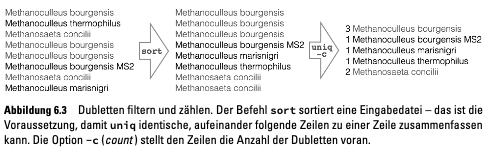

In [ ]:
!awk -F"\t" '$1>99 && $3<4e-45{print $4}' pos-length-evalue-name-readid.archaea.tab | awk '{print $3,$4,$5}' | sort | uniq -c | sort -nr | awk '{org[$2" "$3]+=$1}END{for(i in org){print org[i],i}}' | sort -nr | head -5

In [ ]:
!ls